In [29]:
import gzip
import csv

phedex_columns= ['now_sec','dataset_name','dataset_id','dataset_is_open','create_time',
                'update_time','block_name','block_id','block_files','block_bytes',
                'block_is_open','block_time_create','block_time_update',
                'node_name','node_id','br_is_active','br_src_files',
                'br_src_bytes','br_dest_files','br_dest_bytes',
                'br_node_files','br_node_btyes','br_xfer_files',
                'br_xfer_bytes','br_is_custodial','br_user_group_id',
                'replica_time_create','replica_time_updater']
phedex_colmap={}
for i in range(len(phedex_columns)):
    phedex_colmap[phedex_columns[i]]=i

dataset_col=phedex_colmap['dataset_name']
site_col=phedex_colmap['node_name']
block_col=phedex_colmap['block_name']
replicaTime_col=phedex_colmap['replica_time_create']
size_col=phedex_colmap['block_bytes']
phedex_info={}
n=0
fmt='%Y-%m-%d'
import datetime
import numpy
sumBytes=0
with gzip.open('phedex_det.txt.gz') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if 'MSS' not in row[site_col]: continue

        t=datetime.datetime.fromtimestamp(float(row[replicaTime_col]))
#        tf=t.strftime(fmt)
        rTime=numpy.datetime64(t)
        key=(row[dataset_col],row[block_col],row[site_col])
        if key in phedex_info:
            print 'duplicate',key
            break
        phedex_info[key]=(rTime,float(row[size_col]))
        sumBytes+=float(row[size_col])
            
        if n==0:
            for i in range(len(phedex_columns)):
                print i,row[i],phedex_columns[i]
        #if n==3: break
        n=n+1
     
print("Done reading phedex info")
print len(phedex_info)
print sumBytes

0 1539568028.999999999999999999999999999998 now_sec
1 /LogMonitor/Run2012D-v1/RAW dataset_name
2 557315 dataset_id
3 y dataset_is_open
4 1348765642.50834 create_time
5 null update_time
6 /LogMonitor/Run2012D-v1/RAW#5810fa64-2ff7-11e2-9d5d-842b2b4671d8 block_name
7 3970074 block_id
8 1 block_files
9 862222 block_bytes
10 n block_is_open
11 1353075127.37014 block_time_create
12 1353076085.29089 block_time_update
13 T0_CH_CERN_MSS node_name
14 2 node_id
15 n br_is_active
16 0 br_src_files
17 0 br_src_bytes
18 1 br_dest_files
19 862222 br_dest_bytes
20 1 br_node_files
21 862222 br_node_btyes
22 0 br_xfer_files
23 0 br_xfer_bytes
24 y br_is_custodial
25 18 br_user_group_id
26 1353075127 replica_time_create
27 1353336461.59835 replica_time_updater
Done reading phedex info
3734521
1.83652338705e+17


In [30]:

dates=sorted(set([i[0] for i in phedex_info.values()]))

print dates[0],dates[-1]

2007-06-01T17:28:00.520030 2018-10-15T02:57:36.000000


In [56]:

histo=numpy.zeros(1+ int( (dates[-1]-dates[0]) / numpy.timedelta64(1,'D')) )
histoCERN=numpy.zeros(1+ int( (dates[-1]-dates[0]) / numpy.timedelta64(1,'D')) )

dateList=numpy.arange(dates[0],dates[-1],numpy.timedelta64(1,'D'))
#print len(dateList)
#print len(histo)

keys=phedex_info.keys()
sites={}
for k in keys:
    histo[int( (phedex_info[k][0]-dates[0])/numpy.timedelta64(1,'D'))] +=phedex_info[k][1]/1024./1024./1024./1024./1024.
    if 'CERN' in k[2]:
        histoCERN[int( (phedex_info[k][0]-dates[0])/numpy.timedelta64(1,'D'))] +=phedex_info[k][1]/1024./1024./1024./1024./1024.
    sites[k[2]]=sites.get(k[2],0.)+phedex_info[k][1]/1024./1024./1024./1024./1024.

#print histo[0:100]

#at cern there is the castor space
castorSpace= (81060 - 69829)/1024.
histo[0]+=castorSpace
histoCERN[0]+=castorSpace
sites['T0_CH_CERN_MSS']+=castorSpace

cumsum=numpy.cumsum(histo)
cumsumCERN=numpy.cumsum(histoCERN)

for site in sites:
    print site,sites[site]

4154
4154
[1.22929886e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00771787e-04 1.17713612e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+0

Last six months total 36.9293347085237
Last six months Tier-1 18.187371371947137
Last six months Tier-0 18.741963336576568
Total 174.08381740277576
Tier-1 101.28178978993469
Tier-0 72.80202761284107


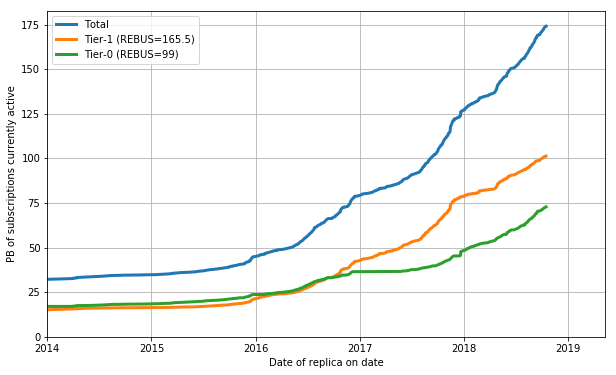

In [58]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6

pylab.plot(dateList,cumsum,linewidth=3)
pylab.plot(dateList,cumsum-cumsumCERN,linewidth=3)
pylab.plot(dateList,cumsumCERN,linewidth=3)

pylab.xlabel('Date of replica on date')
pylab.ylabel('PB of subscriptions currently active')
pylab.ylim(ymin=0)
pylab.xlim(xmin=numpy.datetime64('2014-01-01'))
pylab.legend(['Total','Tier-1 (REBUS=165.5)','Tier-0 (REBUS=99)'],loc='best')
pylab.grid()

print 'Last six months total',cumsum[-1]-cumsum[-180]
print 'Last six months Tier-1',(cumsum[-1]-cumsumCERN[-1])-(cumsum[-180]-cumsumCERN[-180])
print 'Last six months Tier-0',cumsumCERN[-1]-cumsumCERN[-180]

print 'Total',cumsum[-1]
print 'Tier-1',(cumsum[-1]-cumsumCERN[-1])
print 'Tier-0',cumsumCERN[-1]




In [59]:
import json
import urllib2
url = "http://cmsmonitoring.web.cern.ch/cmsmonitoring/storageoverview/latest/StorageOverview.json"
response = urllib2.urlopen(url)
data = response.read()
values = json.loads(data)
tape = values["Tape"]["Used"]
# CERN will not agree as I added the Castor space above
for sitename in tape:
    print sitename,tape[sitename],int(1024.*sites[sitename]),int(1.0995116*1024.*sites[sitename])

T1_RU_JINR_MSS 5970 5424 5964
T1_FR_CCIN2P3_MSS 10196 9272 10194
T1_IT_CNAF_MSS 14561 13219 14535
T1_DE_KIT_MSS 16160 14704 16167
T1_US_FNAL_MSS 50697 46141 50732
T1_ES_PIC_MSS 5478 4985 5481
T1_UK_RAL_MSS 10956 9965 10956
T0_CH_CERN_MSS 69829 74549 81967


In [52]:
#this is the error introduced if you use 10^9 bytes = 1GB 
1.024*1.024*1.024*1.024

1.0995116277760002